As an example, the volatility smile is a `difference from` the Black-Scholes `model` that has been analyzed for a long time in detail.

## Volatility smile

### Related definitions for this topic

#### Moneyness of an option

In the money: with the current spot price of the underlying the option will pay

Out of the money: $\,S_0<K\,$ for call and $\,S_0>K\,$ for put.

At the money (ATM): $\,S_0=K\,$.

#### Over the counter (OTC)

Contracts are usually made
* either `at exchanges` through marketmakers, with fixed conditions and reduced risk,
* or directly between two sides, that is, `OTC` (over-the-counter), with tailored conditions and higher risk.

#### Open interest

For a standardized contract type, this is the number of currently active contracts of this type.

### Observe and Download the data

1. Go to the Yahoo Finance / Tesla / Options page at https://finance.yahoo.com/quote/TSLA/options?p=TSLA.


2. Observe that the listed items are standardized contracts.


3. Above the top left of the "Calls" table there is a date dropdown. Select the date that is closest to your current date.


4. Download the webpage as a single html to the `data` subfolder of your current folder.<br/>
Check that the name of the saved data file contains the spot, for example,<br/>
`MSFT 244.99 0.50 0.20% _ Microsoft Corporation - Yahoo Finance.html`.


### Implied volatility and Open interest

Process the downloaded html file with the code below.


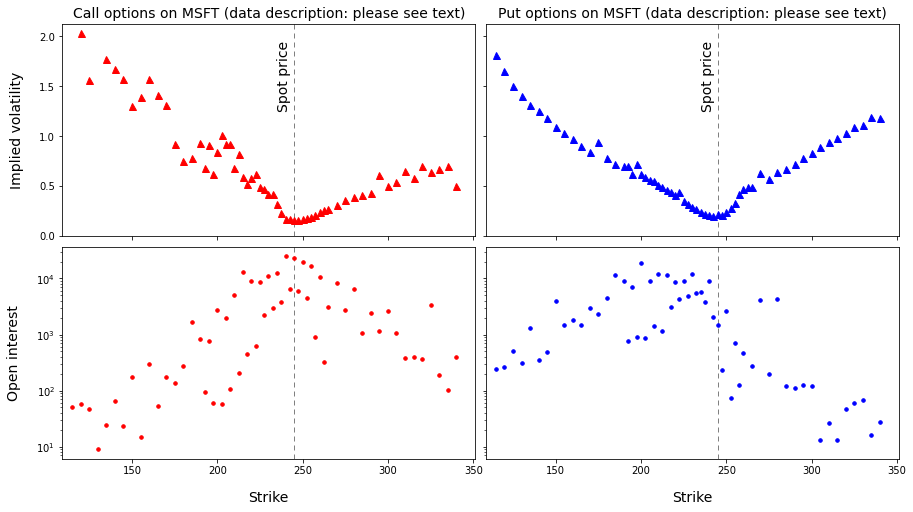

In [3]:
from os.path import join
import re
from collections import OrderedDict
from glob import glob
from matplotlib import pyplot as plt

DATA_DIR = 'data'
STOCK_TICKER = 'MSFT'
DATA_FILE_NAME_PATTERN = STOCK_TICKER + '*Yahoo Finance.html'
FIGURE_SIZE = (15, 8)
OPTION_TYPES = 'call', 'put'
MY_FONTSIZE = 14
LABEL_PAD = 15
TICKS_FONTSIZE = 13
COLOR_LIST = 'red', 'blue'
SUBPLOTS_WIDTH_SPACE = 0.025
SUBPLOTS_HEIGHT_SPACE = 0.05
SPOT_COLOR = 'gray'
SPOT_LINE_WIDTH = 1
SPOT_DASH_LENGTH = (5, 4)


def read_options_data():
    """Read options data from a html file saved from finance.yahoo.com."""

    # --- find the input file and from its name extract the spot price ---
    input_file = glob(join(DATA_DIR, DATA_FILE_NAME_PATTERN))[-1]
    spot = float(list(input_file.split())[1])
    
    # --- read and process the data --- 
    options_data = {option_type: [] for option_type in OPTION_TYPES}
    with open(input_file, encoding='utf8') as f:
        html = f.read()
        options_match = re.match('^.*?<table class=\"calls.+?<tbody.*?>(?P<call>.*?)<\/tbody>'
                                 '.*?<table class=\"puts.+?<tbody.*?>(?P<put>.*?)<\/tbody>', 
                                 html, re.DOTALL)  # matches saved by names: call, put
        if options_match:
            html_tables = {c: options_match.group(c) for c in OPTION_TYPES}
            for option_type, option_table_body in html_tables.items():
                for table_line_match in re.finditer(r'<td class=\"data-col2.*?><a.*?>(.+?)<\/a>.*?'
                                                    r'<td class=\"data-col9.*?>(.+?)<\/td>.*?'
                                                    r'<td class=\"data-col10.*?>(.+?)\%<\/td>',
                                                    option_table_body):
                    strike, open_interest, implied_volatility = (
                        [x.replace(',', '') for x in table_line_match.group(1, 2, 3)])
                    options_data[option_type].append({
                        'strike': float(strike),
                        'open interest': None if open_interest == '-' else int(open_interest),
                        'implied volatility': round(float(implied_volatility) * 0.01, 4)
                    })
        else:
            raise ValueError('Cannot find call and put tables in {}'.format(infile))

    return spot, options_data

            
def plot_options_implied_volatility(spot=None, options_data=None):
    """Plot an analysis of the implied volatility."""
    
    # --- settings ---
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=FIGURE_SIZE)    
    [plt.rc(t, labelsize=TICKS_FONTSIZE) for t in ['xtick', 'ytick']]
    implied_vol_plot_max = {}
    open_interest_plot_limits = {}
    strike_plot_limits = []
    
    # --- compiling data and plotting ---
    for column_index, option_type in enumerate(OPTION_TYPES):

        # --- implied volatility ---
        ax = axes[0][column_index]
        strikes = []
        impl_vols = []
        for dat in options_data[option_type]:
            if dat['implied volatility'] is not None and dat['implied volatility'] > 0.0:
                strikes.append(dat['strike'])
                impl_vols.append(dat['implied volatility'])
        ax.axvline(spot, color=SPOT_COLOR, linewidth=SPOT_LINE_WIDTH, linestyle='--', dashes=SPOT_DASH_LENGTH)
        ax.plot(strikes, impl_vols, 'r-', label='Implied volatility', 
                color=COLOR_LIST[column_index], marker='^', linewidth=0, markersize=7)
        
        implied_vol_plot_max[option_type] = ax.get_ylim()[1]  
        strike_plot_limits.append(ax.get_xlim())
        ax.set_title('{} options on {} (data description: please see text)'
                     .format(option_type.capitalize(), STOCK_TICKER), fontsize=MY_FONTSIZE)
        if column_index == 0:  # show the y axis label only on the left subplot
            ax.set_ylabel('Implied volatility', fontsize=MY_FONTSIZE, labelpad=LABEL_PAD)
        else:  # hide y ticks if we are not at the left subplot
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
        # hide x ticks in the first row
        ax.tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=False)
            
        # --- open interest ---
        ax = axes[1][column_index]
        strikes = []
        open_interests = []
        for dat in options_data[option_type]:
            if dat['open interest'] is not None and dat['open interest'] > 0:
                strikes.append(dat['strike'])
                open_interests.append(dat['open interest'])
        ax.set_yscale('log')
        ax.axvline(spot, color=SPOT_COLOR, linewidth=SPOT_LINE_WIDTH, linestyle='--', dashes=SPOT_DASH_LENGTH)
        ax.plot(strikes, open_interests, 'r-', label='Open interest', 
                color=COLOR_LIST[column_index], marker='.', linewidth=0, markersize=7)

        open_interest_plot_limits[option_type] = ax.get_ylim()
        strike_plot_limits.append(ax.get_xlim())
        ax.set_xlabel('Strike', fontsize=MY_FONTSIZE, labelpad=LABEL_PAD)
        if column_index == 0:
            ax.set_ylabel('Open interest', fontsize=MY_FONTSIZE, labelpad=LABEL_PAD)
        else:
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

    # --- in both rows: setting plot limits equal ---
    implied_vol_plot_min_new = 0.0
    implied_vol_plot_max_new = max(implied_vol_plot_max.values())
    outstanding_interest_plot_min_new = min([y_limits[0] for y_limits in open_interest_plot_limits.values()])
    outstanding_interest_plot_max_new = max([y_limits[1] for y_limits in open_interest_plot_limits.values()])
    strike_plot_min_new = max([limits[0] for limits in strike_plot_limits])
    strike_plot_max_new = max([limits[1] for limits in strike_plot_limits])
    
    for column_index, option_type in enumerate(OPTION_TYPES):
        ax = axes[0][column_index]
        ax.set_xlim((strike_plot_min_new, strike_plot_max_new))
        ax.set_ylim((implied_vol_plot_min_new, implied_vol_plot_max_new))
        ax.text(0.96 * spot, 0.6 * implied_vol_plot_max_new, 
                'Spot price', rotation='vertical', fontsize=MY_FONTSIZE)
        ax = axes[1][column_index]
        ax.set_xlim((strike_plot_min_new, strike_plot_max_new))
        ax.set_ylim((outstanding_interest_plot_min_new, outstanding_interest_plot_max_new))
    
    plt.subplots_adjust(wspace=SUBPLOTS_WIDTH_SPACE, hspace=SUBPLOTS_HEIGHT_SPACE)
    plt.show()

    
spot, options_data = read_options_data()        
plot_options_implied_volatility(spot, options_data)    

### Analyze the result

* Asymmetric smile and open interest

* Differences between Calls and Puts
